In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import types

spark=  SparkSession.builder.master("local[*]").appName("new").getOrCreate()

In [2]:
# sc=spark.sparkContext
df=spark.read.csv(r"D:\Netease\vehicles.csv",header=True,inferSchema=True)

In [3]:

df.show(5)

+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|        id|                 url|              region|          region_url|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission| VIN|drive|size|type|paint_color|image_url|description|county|state| lat|long|posting_date|
+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|7222695916|https://prescott....|            prescott|https://prescott....| 6000|null|        null| null|     null|     null|null|    null|        null|        null|null| null|null|null|       null|     null|       null|  null|  

In [4]:
# drop unnecessary columns
df=df.drop('id','url','region_url','vin','image_url','description','lat','long','county','size','posting_date','paint_color') 
# filter rows that manufacturer and model are not missing
df=df.filter("manufacturer != 'null' and model != 'null'")
df.cache()

DataFrame[region: string, price: string, year: string, manufacturer: string, model: string, condition: string, cylinders: string, fuel: string, odometer: string, title_status: string, transmission: string, drive: string, type: string, state: string]

In [5]:
# since we are interested in the factors that would afffect used car price, we will ignore those observations that price is 0
from pyspark.sql import functions 
df = df.filter(df.price >= 1000)
df = df.withColumn("model_short", functions.substring("model", 1, 2))
df = df.withColumn('cylinders', functions.regexp_extract('cylinders', '\d+', 0).cast('integer'))

df = df.withColumn("year", df["year"].cast(types.IntegerType()))\
    .withColumn("price", df["price"].cast(types.IntegerType()))\
    .withColumn("odometer", df["odometer"].cast(types.IntegerType()))
df.printSchema()

root
 |-- region: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: integer (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- model_short: string (nullable = true)



In [6]:
# count for number of observations
df.count()

361213

In [7]:
df.show(30)

+------+-----+----+------------+--------------------+---------+---------+------+--------+------------+------------+-----+---------+-----+-----------+
|region|price|year|manufacturer|               model|condition|cylinders|  fuel|odometer|title_status|transmission|drive|     type|state|model_short|
+------+-----+----+------------+--------------------+---------+---------+------+--------+------------+------------+-----+---------+-----+-----------+
|auburn|33590|2014|         gmc|sierra 1500 crew ...|     good|        8|   gas|   57923|       clean|       other| null|   pickup|   al|         si|
|auburn|22590|2010|   chevrolet|      silverado 1500|     good|        8|   gas|   71229|       clean|       other| null|   pickup|   al|         si|
|auburn|39590|2020|   chevrolet| silverado 1500 crew|     good|        8|   gas|   19160|       clean|       other| null|   pickup|   al|         si|
|auburn|30990|2017|      toyota|tundra double cab sr|     good|        8|   gas|   41124|       clea

In [8]:
from pyspark.sql import types
# cast datatype into correct types
df = df.withColumn("year", df["year"].cast(types.IntegerType()))\
    .withColumn("price", df["price"].cast(types.IntegerType()))\
    .withColumn("odometer", df["odometer"].cast(types.IntegerType()))
df.printSchema()

root
 |-- region: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: integer (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- model_short: string (nullable = true)



In [9]:
df.show(5)

+------+-----+----+------------+--------------------+---------+---------+----+--------+------------+------------+-----+------+-----+-----------+
|region|price|year|manufacturer|               model|condition|cylinders|fuel|odometer|title_status|transmission|drive|  type|state|model_short|
+------+-----+----+------------+--------------------+---------+---------+----+--------+------------+------------+-----+------+-----+-----------+
|auburn|33590|2014|         gmc|sierra 1500 crew ...|     good|        8| gas|   57923|       clean|       other| null|pickup|   al|         si|
|auburn|22590|2010|   chevrolet|      silverado 1500|     good|        8| gas|   71229|       clean|       other| null|pickup|   al|         si|
|auburn|39590|2020|   chevrolet| silverado 1500 crew|     good|        8| gas|   19160|       clean|       other| null|pickup|   al|         si|
|auburn|30990|2017|      toyota|tundra double cab sr|     good|        8| gas|   41124|       clean|       other| null|pickup|   a

In [10]:
df.count()

361213

In [11]:
price_stats = df.select("price").summary()
t=price_stats.collect()

In [12]:
avg_price=float(t[1][1])
Q3=float(t[-2][1])
Q1=float(t[-4][1])
t

[Row(summary='count', price='361213'),
 Row(summary='mean', price='32106.06230672761'),
 Row(summary='stddev', price='3659470.6001482303'),
 Row(summary='min', price='1000'),
 Row(summary='25%', price='7995'),
 Row(summary='50%', price='15995'),
 Row(summary='75%', price='27990'),
 Row(summary='max', price='1410065407')]

<AxesSubplot:>

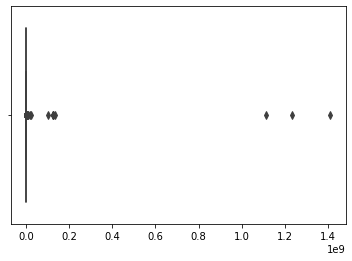

In [13]:
import seaborn as sns
import numpy as np
c=df.select("price").toPandas().values
cleaned_values = c[np.isfinite(c)]

# box plot
sns.boxplot(x=cleaned_values)


In [14]:
# fill nas with mean
df = df.fillna({"price": avg_price})

# perform outliers removal on price column
IQR = Q3 - Q1
IQR

19995.0

<AxesSubplot:>

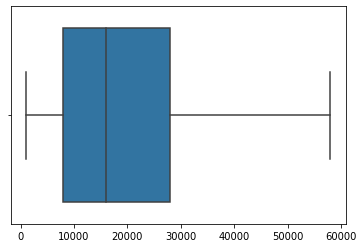

In [15]:
from pyspark.sql import functions
df = df.withColumn("price", functions.when((functions.col("price") < Q1-1.5*IQR),Q1-1.5*IQR).when(functions.col("price") > Q3+1.5*IQR, avg_price).otherwise(functions.col("price")))
price_stats = df.select("price").summary()
t1=price_stats.collect()
t1
#3 visualize new price 
c=df.select("price").toPandas().values
cleaned_values = c[np.isfinite(c)]

# box plot
sns.boxplot(x=cleaned_values)

In [16]:
df.show(5)

+------+-------+----+------------+--------------------+---------+---------+----+--------+------------+------------+-----+------+-----+-----------+
|region|  price|year|manufacturer|               model|condition|cylinders|fuel|odometer|title_status|transmission|drive|  type|state|model_short|
+------+-------+----+------------+--------------------+---------+---------+----+--------+------------+------------+-----+------+-----+-----------+
|auburn|33590.0|2014|         gmc|sierra 1500 crew ...|     good|        8| gas|   57923|       clean|       other| null|pickup|   al|         si|
|auburn|22590.0|2010|   chevrolet|      silverado 1500|     good|        8| gas|   71229|       clean|       other| null|pickup|   al|         si|
|auburn|39590.0|2020|   chevrolet| silverado 1500 crew|     good|        8| gas|   19160|       clean|       other| null|pickup|   al|         si|
|auburn|30990.0|2017|      toyota|tundra double cab sr|     good|        8| gas|   41124|       clean|       other| nu

In [17]:
from pyspark.sql import DataFrame
def clean(dataframe: DataFrame, COL: str) -> DataFrame:
    '''
    Take a spark dataframe and a column name (COL)
    Calculate the summary statistics for the column and clean the column with calculated values
    '''

    column_stats = dataframe.select(COL).summary()
    stats = column_stats.collect()

    avg = float(stats[1][1])
    Q3 = float(stats[-2][1])
    Q1 = float(stats[-4][1])
    IQR = Q3 - Q1

    # Fill missing values with average
    dataframe = dataframe.fillna({COL: avg})

    dataframe = dataframe.withColumn(
        COL,
        functions.when(functions.col(COL) < Q1 - 1.5 * IQR, Q1 - 1.5 * IQR)
        .when(functions.col(COL) > Q3 + 1.5 * IQR, avg)
        .otherwise(functions.col(COL))
    )

    return dataframe


In [18]:
numeric_columns=["year","odometer","cylinders"]
for col in numeric_columns:
    df = clean(df, col)

In [19]:
categorical_columns=["region","fuel","drive","type","manufacturer","transmission","title_status","model","condition","state"]

In [20]:
# filling categorical missing values with "unknown"
for col in categorical_columns:
    df = df.withColumn(col, functions.when(df[col].isNull(), "Unknown").otherwise(df[col]))

In [21]:
df.cache()

DataFrame[region: string, price: double, year: double, manufacturer: string, model: string, condition: string, cylinders: double, fuel: string, odometer: double, title_status: string, transmission: string, drive: string, type: string, state: string, model_short: string]

In [22]:
#making sure there is no NAs

from pyspark.sql.functions import col, when, isnull, isnan, count

# 获取 DataFrame 中的所有列名
all_columns = df.columns

# 创建一个包含所有列的表达式，用于检查每个列中的空值（null 或 NaN）
null_check_expr = [count(when(isnull(col(c)) | isnan(col(c)), c)).alias(c) for c in all_columns]

# 使用上述表达式，聚合 DataFrame 并计算每个列中的空值数量
null_counts = df.select(null_check_expr).collect()

# 将空值计数结果转换为字典
null_counts_dict = {c: null_counts[0][c] for c in all_columns}

# 输出每个列的空值计数
for column, null_count in null_counts_dict.items():
    print(f"{column}: {null_count} null values")


region: 0 null values
price: 0 null values
year: 0 null values
manufacturer: 0 null values
model: 0 null values
condition: 0 null values
cylinders: 0 null values
fuel: 0 null values
odometer: 0 null values
title_status: 0 null values
transmission: 0 null values
drive: 0 null values
type: 0 null values
state: 0 null values
model_short: 0 null values


In [23]:
# machine learning model
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# feature engineering
numeric_columns=["year","odometer","cylinders"]
categorical_columns=["region","fuel","drive","type","manufacturer","transmission","title_status","model","condition","state"]
output_columns = [f"{c}_index" for c in categorical_columns] + numeric_columns

indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep") for c in categorical_columns]
encoder = OneHotEncoder(inputCols=[f"{c}_index" for c in categorical_columns], outputCols=[f"{c}_ohe" for c in categorical_columns])
assembler = VectorAssembler(inputCols=[f"{c}_ohe" for c in categorical_columns] + numeric_columns, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")



In [24]:
df.show(5)
df.printSchema()

+------+-------+------+------------+--------------------+---------+---------+----+--------+------------+------------+-------+------+-----+-----------+
|region|  price|  year|manufacturer|               model|condition|cylinders|fuel|odometer|title_status|transmission|  drive|  type|state|model_short|
+------+-------+------+------------+--------------------+---------+---------+----+--------+------------+------------+-------+------+-----+-----------+
|auburn|33590.0|2014.0|         gmc|sierra 1500 crew ...|     good|      8.0| gas| 57923.0|       clean|       other|Unknown|pickup|   al|         si|
|auburn|22590.0|2010.0|   chevrolet|      silverado 1500|     good|      8.0| gas| 71229.0|       clean|       other|Unknown|pickup|   al|         si|
|auburn|39590.0|2020.0|   chevrolet| silverado 1500 crew|     good|      8.0| gas| 19160.0|       clean|       other|Unknown|pickup|   al|         si|
|auburn|30990.0|2017.0|      toyota|tundra double cab sr|     good|      8.0| gas| 41124.0|   

In [25]:

# 选择回归模型
lr = LinearRegression(featuresCol="scaled_features", labelCol="price")

# 构建数据处理和模型训练管道
pipeline = Pipeline(stages=indexers + [encoder, assembler, scaler, lr])

# 拆分数据集为训练集和测试集
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# 训练模型
model = pipeline.fit(train_data)

In [26]:

# 应用模型于测试集
predictions = model.transform(test_data)

# 选择要显示的列
predictions.select("price", "prediction", "scaled_features").show(5)

# 初始化回归评估器
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")

# 计算评估指标
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})

# 打印评估指标
print("regression result")
print(f"R2 score: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

+------+-------------------+--------------------+
| price|         prediction|     scaled_features|
+------+-------------------+--------------------+
|1100.0|-1719.9556406079791|(29279,[10,406,41...|
|1200.0| 3294.0714814579114|(29279,[10,406,41...|
|1234.0| 3301.8617851485033|(29279,[10,406,41...|
|1600.0|  3604.922647776315|(29279,[10,406,41...|
|1900.0|   567.569230816327|(29279,[10,406,41...|
+------+-------------------+--------------------+
only showing top 5 rows

regression result
R2 score: 0.8446538749608786
Mean Squared Error: 24363704.656741563
Root Mean Squared Error: 4935.960358100699


In [27]:
lasso = LinearRegression(featuresCol="scaled_features", labelCol="price", regParam=0.7, elasticNetParam=1.0)
# 构建数据处理和模型训练管道
pipeline = Pipeline(stages=indexers + [encoder, assembler, scaler, lasso])
# 训练模型
lasso_model = pipeline.fit(train_data)

In [28]:
# apply model
predictions = lasso_model.transform(test_data)

# 选择要显示的列
predictions.select("price", "prediction", "scaled_features").show(5)

# 初始化回归评估器
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")

# 计算评估指标
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})

# 打印评估指标
print("regression result")
print(f"R2 score: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

+------+------------------+--------------------+
| price|        prediction|     scaled_features|
+------+------------------+--------------------+
|1100.0| 3213.832731873961|(29279,[10,406,41...|
|1200.0|3329.6051487433724|(29279,[10,406,41...|
|1234.0|3518.6913092120085|(29279,[10,406,41...|
|1600.0| 3615.399094182765|(29279,[10,406,41...|
|1900.0| 558.0919348474126|(29279,[10,406,41...|
+------+------------------+--------------------+
only showing top 5 rows

regression result
R2 score: 0.8463705712467313
Mean Squared Error: 24094466.648498315
Root Mean Squared Error: 4908.611478666682


In [30]:
lr_model = model.stages[-1]
coefficients = lr_model.coefficients
assembler_input_cols = assembler.getInputCols()
coefficients_list = coefficients.tolist()
feature_coefficient_tuples = list(zip(assembler_input_cols, coefficients_list))
# result_df = spark.createDataFrame(feature_coefficient_tuples, ["feature", "coefficient"])
# result_df.show(5)

# ----------------------------------------------------------------
# what factors are related to car price?
sorted(feature_coefficient_tuples,key=lambda x: abs(x[1]),reverse=True)

[('year', 274.8104337413023),
 ('transmission_ohe', -121.31184588594033),
 ('region_ohe', -120.94110115909548),
 ('manufacturer_ohe', -109.93670199487468),
 ('type_ohe', -84.02400318646083),
 ('condition_ohe', -46.45417931079852),
 ('fuel_ohe', -36.91203730515515),
 ('state_ohe', 34.6842441116515),
 ('cylinders', -33.15853131590565),
 ('odometer', 15.192033546348265),
 ('model_ohe', 11.177593784747588),
 ('title_status_ohe', -8.3914553399019),
 ('drive_ohe', 6.208809909628746)]

### insights: 
###### the major factors that affect userd car prices are year, odometer(mileage), and regions. It suggests that being in different regions can significantly affect your car price
###### aother interesting finding is that in used car markets, more cylinders car(higher performance cars) will decrease the car's value, probably due to maintenance concerns
###### popular used cars with high resell values such as (toyota, honda) usually have 4 cylinders
###### four wheel drives will increase the car's value


In [79]:
from pyspark.sql.functions import avg

# 选择Toyota品牌的车辆数据
toyota_df = df.filter((df["manufacturer"] == "toyota") & (df["condition"] == "good"))


# 按照年份计算每年Toyota车型的平均价格
toyota_average_price_by_year = toyota_df.filter((toyota_df["year"] >= 2012) & (toyota_df["year"] <= 2024))\
    .groupBy("year").agg(avg("price")).orderBy("year").collect()

# 计算每行驶1英里所降低的价格
average_price_per_mile = toyota_df.groupBy().agg(avg("price")/avg("odometer")).collect()[0][0]


In [82]:


bmw_df = df.filter((df["manufacturer"] == "bmw") & (df["condition"] == "good"))

bmw_average_price_by_year = bmw_df.filter((bmw_df["year"] >= 2012) & (bmw_df["year"] <= 2024))\
    .groupBy("year").agg(avg("price")).orderBy("year").collect()


average_price_per_mile = bmw_df.groupBy().agg(avg("price")/avg("odometer")).collect()[0][0]




In [ ]:
from pyspark.sql.functions import avg

# 选择Mercedes-Benz品牌的车辆数据
mercedes_df = df.filter(df["manufacturer"] == "mercedes-benz")

# 选择生产年份早于2012年的车辆数据
mercedes_df_10years = mercedes_df.filter(mercedes_df["year"] < 2012)

# 计算十年以上车龄的平均价格
average_price_10years = mercedes_df_10years.groupBy().agg(avg("price")).collect()[0][0]

# 按照年份计算每年Mercedes-Benz车型的平均价格
average_price_by_year = mercedes_df.groupBy("year").agg(avg("price")).orderBy("year").collect()

# 计算每行驶1英里所降低的价格
average_price_per_mile = mercedes_df.groupBy().agg(avg("price")/avg("odometer")).collect()[0][0]


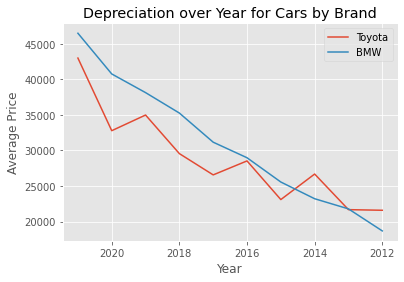

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
average_price_by_year_df = pd.DataFrame(toyota_average_price_by_year, columns=["year", "average_price"])
bmw_average_price_by_year=pd.DataFrame(bmw_average_price_by_year, columns=["year", "average_price"])
plt.plot(average_price_by_year_df["year"], average_price_by_year_df["average_price"], label="Toyota")
plt.plot(bmw_average_price_by_year["year"], bmw_average_price_by_year["average_price"], label="BMW")
plt.title("Depreciation over Year for Cars by Brand")
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.gca().invert_xaxis()  # 反转x轴
plt.legend()
plt.savefig("my_plot1.png",dpi=300)

<Figure size 432x360 with 0 Axes>

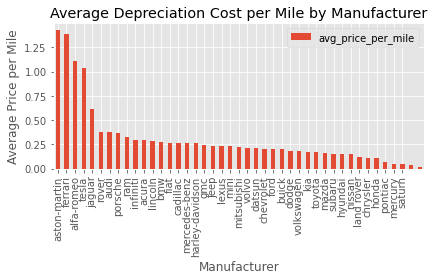

In [134]:
# 计算每个制造商的平均价格和平均里程
# 计算每个制造商的平均价格和平均里程
avg_price_mileage = df.groupBy("manufacturer").agg(avg("price").alias("avg_price"), avg("odometer").alias("avg_mileage"))
avg_price_per_mile = avg_price_mileage.withColumn("avg_price_per_mile", avg_price_mileage["avg_price"] / avg_price_mileage["avg_mileage"])
# 将结果转换为Pandas DataFrame，并按照平均每英里价格从高到低排序
result_df = avg_price_per_mile.select("manufacturer", "avg_price_per_mile").orderBy("avg_price_per_mile", ascending=False).toPandas()
# 设置Matplotlib主题
plt.style.use('ggplot')
# 创建一个bar graph
plt.figure(figsize=(6,5))
ax = result_df.plot(kind="bar", x="manufacturer", y="avg_price_per_mile")
ax.set_title("Average Depreciation Cost per Mile by Manufacturer")
ax.set_xlabel("Manufacturer")
ax.set_ylabel("Average Price per Mile")
ax.set_xticks(ax.get_xticks()[:-2])
plt.tight_layout() 
# 显示图形
# plt.show()
plt.savefig("my_plot.png",dpi=300)



In [119]:
plt.savefig("my_plot.png")

<Figure size 432x288 with 0 Axes>

In [44]:
spark.stop()

In [ ]:
Used Car Market Analysis